# Speaker-Independent Spoken Digit Recognition (xSDR)


One of the successful stories of deep neural networks is the proliferation of commercial of automatic speech recognition (ASR) systems. This project aims to explore one application of ML-powered ASR to the problem of spoken digit recognition (SDR). Since digits are widely used as unique identifiers for bank information, social security numbers, post codes, etc, SDR systems can be an efficient alternative to fully-fledged ASR systems since the domain is more predictable than other applications of ASR. 

In this project, we focus on developing a SDR system in a speaker-independent setting. That is, the speakers in the evaluation set are disjoint from the training set speakers. We do so because we expect real-world ASR systems to generalize to different speakers than those we have data for. Moreover, for many languages that are under-resourced, we have have (limited) annotated speech data from a single speaker, but we would still want the system to be deployed to work on any speaker of that language. We tackle the problem of spoken digit recognition as a sequence classification task. Concretely, the inputs are short audio clips of a specific digit (in the range 0-9), then the goal is to build deep neural network models to classify a short audio clip and predict the digit that was spoken.

# Notes

## Code Submission

You don't necessarily need to complete the code in this Jupyter Notebook, you are free to use another notebook or a python script file, as you would like. You are expected to submit the code by **22.03.2023**.

Your code should be clean and well commented. We also expect that if we decide to run it on our system, it should be straighforward to do so. We recommend creating a ```requirements.txt``` file with the names of all the libraries with their versions. If applicable, please mention the python version in a ```README.md``` file, which should also include instructions on how to run your code.

As mentioned for the assignments, always remember to cite the code with the links as comments, if you decide to use it from a public repository.

## Report Submission

With the code, you are also expected to submit a report with a maximum of 4 pages. You should write your report in LaTeX using this template for ACL 2023 [Overleaf Link](https://www.overleaf.com/latex/templates/acl-2023-proceedings-template/qjdgcrdwcnwp). Use this document to fill in any missing information that are not necessarily covered during your presentation for the sake of time in the presentation. While writing your report, we would highly encourgae you to cite the papers behind each tool / library / function that you might use for your experiments. We have also released an example on how to write equations in LaTeX [here](https://piazza.com/class/l9so16qqvk34hu/post/52).

You art also expected to submit this report with your code. You should provide the **.tex, .pdf and all image files** zipped with the same naming convention as it was in your assignment(s).

## Presentation

During the last week of March 2023, i.e. 27.03 -- 31.03, each team will be presenting their works for 15 minutes. We expect equal contribution from each member in delivery and content of the presentation. So roughly 5 minutes for one person, if you have 3 people in your team. There will be 5 minutes for some Q&A. At-least one person from your team should be present to do an in-person presentation, rest of your team could join remotely, if they are not present.

## Important Dates

 - Code & Report Submission: 22.03.2023 (08.00)
 - Presentation: 27.03.2023 -- 31.03.2023
 
 You'll get a precise date and time for your team's presentation at a later time.

### Grading

In this project, your final grades will be determined as follows:

 - **30%**: &emsp; Completing all the tasks
 - **30%**: &emsp; Providing scientific-backings for all the methods used
 - **20%**: &emsp; Quality of the content of the presentation
 - **20%**: &emsp; Delivery of the presentation

In [1]:
#%matplotlib inline
import numpy as np
import scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
import torch
import pandas as pd

from sklearn  import preprocessing


from collections import defaultdict, Counter

# add this to ignore warnings from Librosa
import warnings
warnings.filterwarnings('ignore')

import random

In [2]:
# for linear models 
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
from sklearn.neural_network import MLPClassifier

In [4]:
torch.cuda.is_available()
device = torch.device("cuda")

## Exploring the Dataset 

The speech samples are already divied into training, development, and test spilts. The splits are made in such way that evaluation speakers are not present in training split. You should use the splits as they are. 

**CAUTION:** 

In this project, you are not allowed to use any external data for this problem (at least for the main three tasks). Exploring the effect of additional datasets in this project can only included as a further step after completing the main requirements with the given data. 

In [5]:
# read tsv file into a dataframe 
sdr_df = pd.read_csv('SDR_metadata.tsv', sep='\t', header=0, index_col='Unnamed: 0')

In [6]:
sdr_df.head()

,identifier,speaker,split,label,file
0,5_theo_23,theo,TRAIN,5,speech_data/5_theo_23.wav
1,2_yweweler_39,yweweler,TEST,2,speech_data/2_yweweler_39.wav
2,6_yweweler_34,yweweler,DEV,6,speech_data/6_yweweler_34.wav
3,6_yweweler_16,yweweler,DEV,6,speech_data/6_yweweler_16.wav
4,9_yweweler_2,yweweler,TEST,9,speech_data/9_yweweler_2.wav


In [7]:
set(sdr_df.speaker.values)

{'george', 'jackson', 'lucas', 'nicolas', 'theo', 'yweweler'}

In [8]:
# explore one sample: 7_theo_0
sdr_df.loc[sdr_df['identifier'] == '7_theo_0']

,identifier,speaker,split,label,file
700,7_theo_0,theo,TRAIN,7,speech_data/7_theo_0.wav


In [9]:
sample_wav_file = sdr_df.loc[sdr_df['identifier'] == '7_theo_0'].file[700]

## The Speech Waveform

The acoustic realization of speech segment can be (digitally) viewed as a time-variant wavform $\mathbf{S} \in \mathbb{R}^{n}$. Here, $n$ depends on both the duration of the speech segment and the sampling rate of the continous speech singal. Let's check out one sample from the data set. 

In [10]:
# play and listen to a sample 
SAMPLING_RATE = 8000 # This value is determined by the wav file, DO NOT CHANGE

x, sr = librosa.load(sample_wav_file, sr=SAMPLING_RATE) #, 
ipd.Audio(x, rate=sr)

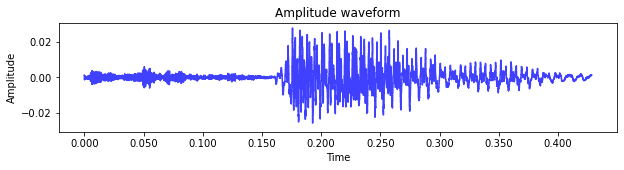

In [11]:
# plot as a waveform 
fig, ax = plt.subplots(figsize=(10, 2), sharex=True)

img = librosa.display.waveshow(y=x, sr=sr, alpha=0.75, x_axis='time', color='blue')

ax.set(title='Amplitude waveform')
ax.set_ylabel('Amplitude')
ax.label_outer()

In [12]:
# sample duration in milliseconds
(1000*len(x))/SAMPLING_RATE

428.5

In the cell above, you can see the temporal duration of the audio is 428.5 milliseconds. For digits in the range 0-9, the duration of the speech segment should be around 0.5 seconds with reasonable variation depending on speech rate (i.e., how fast the speaker speaks). 

## The Speech Signal Representation - Mel Spectrograms

Humans can recognize and differentiate different speech sounds based on the frequency characteristics of the sounds. For machine learning applications, human speech is represented using spectro-temporal features in the [Mel-scale](https://en.wikipedia.org/wiki/Mel_scale) extracted from the speech sample. Mel-scale features are inspired by human speech perception and auditory processing whereby the human ear has difference sensitivity (or resolution) in differet frequency bandes. That is, the human ear can better recognize differences in in lower range frequences, while higher range frequences have a lower resolution. The Mel-scale is linear for frequencies in the range (0-1kHz), and logarithmic for frequencies above 1kHz.

In the spectro-temporal representation of speech, a speech sample can be seen as a sequence of $T$ spectral vectors as $\mathbf{X} = (\mathbf{x}^1, \mathbf{x}^2, \dots, \mathbf{x}^T)$. Each spectral vector $\mathbf{x}^t \in \mathbb{R}^{k}$ at time-step $t$ is extracted from a short speech segment (~25 milliseconds) with the assumption that the signal is time-invariant in this small time window. Here, $k$ is the number of frequency bands in the [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) and this is a parameter of the feature extraction pipeline. The representation is based on the Fourier transform to convert the temporal signal into the frequency domain. 

In automatic speech recognition (ASR) research and applications, spectral vectors are usually referred to as "acoustic frames". Morover, adjacent frames are extracted with some overlap between them, usually ~10 milliseconds. 

In [13]:
def extract_melspectrogram(signal, sr, num_mels):
    """
    Given a time series speech signal (.wav), sampling rate (sr), 
    and the number of mel coefficients, return a mel-scaled 
    representation of the signal as numpy array.
    """
    
    mel_features = librosa.feature.melspectrogram(y=signal,
        sr=sr,
        n_fft=200, # with sampling rate = 8000, this corresponds to 25 ms
        hop_length=80, # with sampling rate = 8000, this corresponds to 10 ms
        n_mels=num_mels, # number of frequency bins, use either 13 or 39
        fmin=50, # min frequency threshold
        fmax=4000 # max frequency threshold, set to SAMPLING_RATE/2
    )
    
    # for numerical stability added this line
    mel_features = np.where(mel_features == 0, np.finfo(float).eps, mel_features)

    # 20 * log10 to convert to log scale
    log_mel_features = 20*np.log10(mel_features)

    # feature scaling
    scaled_log_mel_features = preprocessing.scale(log_mel_features, axis=1)
    
    return scaled_log_mel_features

In [14]:
melspectrogram = extract_melspectrogram(x, sr, num_mels=13)

melspectrogram.shape

(13, 43)

Note that the shape of the array (K x T) represents the number of frequency bands (K) and the number of spectral vectors in this representation (here, K=13, T=43). K is a hyperparameter and the recommended values in ASR research are (13, 39, 81, etc). Here, we fix K = 13. On the other hand, T varies from sample to sample depending on the duration of the sample.  

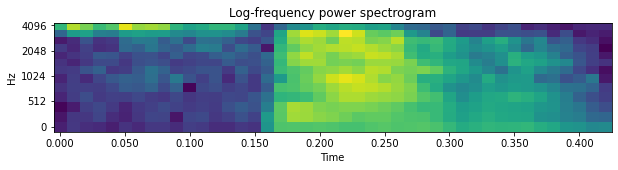

In [15]:
# plot and view the spectrogram

fig, ax = plt.subplots(figsize=(10, 2), sharex=True)

img = librosa.display.specshow(
    melspectrogram, 
    sr=sr, 
    x_axis='time', 
    y_axis='mel', 
    cmap='viridis', 
    fmax=4000, 
    hop_length=80
)

ax.set(title='Log-frequency power spectrogram')

ax.label_outer()

As you can see above from the figure, the spectrogram representation can be viewed as a matrix $\mathbf{X} \in \mathbb{R}^{T} \times \mathbb{R}^{k}$.  

## Task I
1. One problem with the spectrogram as a speech feature represetation is that different speech samples would have dfferent durations due to inherent speech variability (e.g., speech rate, speaker dialect, etc). That is, the $T$ in the $(T \times k)$-dimensional representation would be different for each sample. Therefore, for the baseline model, we will implement a method to have a fixed-size representation for all speech samples. Write a function downsample_spectrogram(X, N) that takes as input a spectrogram $\mathbf{X} \in \mathbb{R}^{T \times k}$ and a parameter N <= 25. The function should (1) make N equally-sized splits of S across the time-axis, (2) apply a pooling technique (e.g., mean pooling) to each split across the frequency axis to obtain an array that represents a downsampled version of the spectrogram $\mathbf{X}' \in \mathbb{R}^{N \times k}$, and (3) re-arange $\mathbf{X}'$ as a vector $\mathbf{v} \in \mathbb{R}^{Nk}$.    

2. Using the downsample_spectrogram(X, N) function, transform all the speech samples into vectors $\mathbf{v} \in \mathbb{R}^{Nk}$. 

3. Given the speaker-based train/dev/test spilts in the SDR_metadata.tsv, fit a linear model on the training samples. That is, your model should be build on data from 4 speakers {'nicolas', 'theo' , 'jackson',  'george'}. Hint: you can experiment with a few model alternatives in the SGDClassifier module in scikit-learn. 

4. Evaluate you model on the dev and test splits. Use accuracy as an evaluation metric. Analyze the model performance using a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) of the all possible labels (0-9), Analyze [precision, recall](https://en.wikipedia.org/wiki/Precision_and_recall), [F1-score](https://en.wikipedia.org/wiki/F-score) for each label. Report your observation.

In [16]:
def downsample_spectrogram(X, N):
    """
    Given a spectrogram of an arbitrary length/duration (X ∈ K x T), 
    return a downsampled version of the spectrogram v ∈ K * N
    """
    # ... your code here
    pass 
    return v

## Baseline Model

In [17]:
# prepare data and split 

# train a linear model 

# evaluate the model using accuracy metric

# analyze the confusion matrix of the baseline 

# report precision, recall, F1-score for each label 

## Task II
1. Having established a baseline with a linear model trained on a downsampled signal representation of the speech segment, this task aims to learn a classifier based on the full speech segment. To this end, you will implement a neural model that is suitable for sequential data such as recurrent DNN, convolutional DNN with 1-D temporal convolution, or an audio transformer. The model should take the acoustic sample as it is (i.e., the Mel spectrogram could have an arbitrary length) without the need to downsample the segment. You need to implement at least two of the aforementioned models. Do the neural models improve accuracy over the baseline model? Do you observe any signs of overfitting to the training data? How do the hyperparameters affect the model performance? Report and discuss your observations.        

2. Evaluate your (best) neural models and compare to the baseline model using the same evalution process as in task I.4. 

3. Use a dimensionality reduction algorithm such as t-SNE \[[1](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding),[2](https://pypi.org/project/tsne-torch/),[3](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)\] or [UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html) to analyze how the different models seperate the different classes (the last non-linear layer in your model). Compare to the downsampled representation you used in the baseline and report your observations.

4. Are the differences between the different models statistically significant? To answer this question, you need to implement a statistical significance test based on bootstrapping method. To read more how to estiame p-values based on bootstrapping, we recommend the materials on this paper https://aclanthology.org/D12-1091.pdf. Include the baseline model in your evaluation. 

## Task III (Open Ended)
1. Consider the case where we have speech data from a single speaker (e.g., george). Train your models on this subset of the data. What do you observe? How does this affect the model performance? 

2. Even though a model is trained on a single speaker, we would like the model to generalizes to any speaker. To this end, one can use data augmentation techniques to artificially create more samples for each class. Some of these augmentations can be applied on the spectrogram (e.g., SpecAugment https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html), and other can be applied on the raw waveform before creating the spectrogram such as pitch manipulation (https://github.com/facebookresearch/WavAugment). Explore the effect of one type of augmentation from each type. Report your observation and anaylze the confusion matrices.

3. Data augmentation techniques create different "views" of each training sample in a stochastic or determinstic approach. One can leaverage speech data augmentation to create views for training a neural network in a contrastive learning setting with margin-based objective function (for more info, read http://proceedings.mlr.press/v130/al-tahan21a/al-tahan21a.pdf). Implement at least one model using a contrastive loss based on different views of the training samples. Does this model improve over the model without contrastive learning? Report and discuss your observations. 

For more information on the contrastive learning framework, you can refer to this paper
https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9226466

In [18]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F
from tqdm import tqdm
from torchmetrics import F1Score
from torch.utils.data import Dataset,DataLoader

In [19]:
class customDataset(Dataset):
    def __init__(self, datalist, labels):
        self.labels = labels
        self.datalist = datalist 
        
    def __len__(self):
        return self.datalist.shape[0]
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.datalist[idx]
        return data, label


class customDataLoader(DataLoader):
    def __init__(self, customdata, batch_size, collate_fn=None):
        self.customdata = customdata
        self.batch_size = batch_size

    def loader(self):
        return DataLoader(self.customdata, self.batch_size)

In [20]:
###Helper function
#calculating loss over a dataset
def test(model,test_loader):
        loss_fn = nn.CrossEntropyLoss()
        loss=0
        for i,(xs,ys) in enumerate(test_loader):
            xs=xs.to(device)
            ys=ys.to(device)
            pred = model.forward(xs.type(torch.FloatTensor).cuda())
            loss+= loss_fn(pred,ys).item()
        print(loss/len(test_loader))
        return (loss/len(test_loader))
##function to get accuracy:
def get_accuracy(data,model):
    accdata=data
    train_acc=0
    i=0
    for X,Y in accdata:
        i+=len(X)
        X=X.to(device)
        Y=Y.to(device)
        ypred=model.forward(X.type(torch.FloatTensor).cuda())
        train_acc += torch.sum(ypred.argmax(1) == Y)
    accuracy = train_acc/i
    
    print(accuracy.item()*100,"%")
    return (accuracy.item())

def get_f1(data,model):
    accdata=data
    for X,Y in accdata:
        X=X.to(device)
        Y=Y.to(device)
        f1= F1Score(task="multiclass", num_classes=10).to(device)
        ypred=model.forward(X.type(torch.FloatTensor).cuda())
        f1 = f1(ypred.argmax(1),Y)
    print("F1 score:",f1.item())
    return (f1.item())

def plot(lossrec,par):
    fig, axs = plt.subplots(1,2,figsize=(20,7))
    axs[0].set_title('epoch vs log loss')
    axs[0].plot(range(len(lossrec)),lossrec,color='orange',label='Training loss')
    axs[0].set_xlabel('epochs')
    axs[0].set_ylabel('log loss')
    axs[1].plot(range(len(par)),par,marker='o',color='violet',label='weight grad')
    axs[1].set_ylabel('norm of weights grad')
    axs[1].set_xlabel('epochs')
    axs[1].set_title('change of weight grad over epochs ')
    axs[1].legend()
    plt.show()
def create_embedding(data,model):
    accdata=data
    train_acc=0
    i=0
    for X,Y in accdata:
        ypred=model.forward(X.type(torch.FloatTensor).cuda())
    return ypred,Y
def tsne_map(testdl2,modellstm):
    embeds,labels=create_embedding(testdl2,modellstm)
    X_emb = tsne(n_components=2,init='random', perplexity=3).fit_transform(embeds.cpu().detach().numpy())
    color_dict={0:'#6B2737',1:'#A65B3E',2:'#E08E45',3:'#ECC176',4:'#F8F4A6',5:'#DBF6AF',6:'#BDF7B7',7:'#9CCAB7',8:'#7B9DB7',9:'#3943B7'}
    fig=plt.figure(figsize=(10,10))
    rec=[]
    for i in range(X_emb.shape[0]):
        if labels[i].item() not in rec:
            rec.append(labels[i].item())
            plt.scatter(X_emb[i][0],X_emb[i][1],color=color_dict[labels[i].item()],label=str(labels[i].item()))
        else:
            plt.scatter(X_emb[i][0],X_emb[i][1],color=color_dict[labels[i].item()])
    plt.xlabel("axis 1")   
    plt.ylabel("axis 2")
    plt.title("T-SNE plot")
    plt.legend()
def confusionplot(data,model):
    accdata=data
    for X,Y in accdata:
        X=X.to(device)
        Y=Y.to(device)
        y_pred=torch.argmax(model.forward(X.type(torch.FloatTensor).cuda()),dim=1)
    cf_matrix = confusion_matrix(Y.cpu(), y_pred.cpu())
    classes = (0,1,2,3,4,5,6,7,8,9)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                         columns = [i for i in classes])
    plt.figure(figsize = (12,10))
    sn.heatmap(df_cm, annot=True)
def classificationReport(data,model):
    accdata=data
    for X,Y in accdata:
        X=X.to(device)
        Y=Y.to(device)
        y_pred=torch.argmax(model.forward(X.type(torch.FloatTensor).cuda()),dim=1)
    print(classification_report(Y.cpu(), y_pred.cpu(), labels=list(range(10))))

In [21]:
## data processing

# determining the longest sequence
maxlength=0
for path,split,label in zip(sdr_df['file'],sdr_df['split'],sdr_df['label']):
        x, sr = librosa.load(path, sr=SAMPLING_RATE)
        melspectrogram = extract_melspectrogram(x, sr, num_mels=13)
        if maxlength < melspectrogram.shape[1]:
            maxlength = melspectrogram.shape[1]
print(maxlength)

229


In [22]:
max_val = -np.inf
for path, split, label in zip(sdr_df['file'], sdr_df['split'], sdr_df['label']):
    x, sr = librosa.load(path, sr=SAMPLING_RATE)
    melspectrogram = extract_melspectrogram(x, sr, num_mels=13)
    if np.max(melspectrogram) > max_val:
        max_val = np.max(melspectrogram)

In [23]:
def manipulate(data, sampling_rate, shift_max, shift_direction):
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    # Set to silence for heading/ tailing
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    return augmented_data

### Model1: 1D CNN based

In [24]:
dummy=np.zeros((1,melspectrogram.shape[0],maxlength+27))
datadict = {'TRAIN':dummy,'DEV':dummy,'TEST':dummy}
labeldict = {'TRAIN':[],'DEV':[],'TEST':[]}
for path,split,label in zip(sdr_df['file'],sdr_df['split'],sdr_df['label']):
        x, sr = librosa.load(path, sr=SAMPLING_RATE)
        melspectrogram = extract_melspectrogram(x, sr, num_mels=13)/max_val
        data = torch.tensor(np.concatenate((melspectrogram,np.zeros((melspectrogram.shape[0],maxlength-melspectrogram.shape[1]+27))),axis = 1))## the dimension is made to be 256 so that it works with the maxpooling layers in the architecture.
        data = data.view(1,melspectrogram.shape[0],-1) 
        datadict[split]=torch.tensor(np.concatenate((datadict[split],data),axis=0))
        labeldict[split].append(label)
#train_data = datadict['TRAIN'][1:]
test_data = datadict['TEST'][1:]
val_data = datadict['DEV'][1:]
#train_y = labeldict['TRAIN'] 
test_y = labeldict['TEST']
val_y = labeldict['DEV']

In [25]:
class cnnModel(nn.Module):
    def __init__(self, input_dim, kernel_size,d):
        super(cnnModel, self).__init__() 
        self.input_dim = input_dim
        self.k_size = kernel_size 
        self.d=d
        layers = []
        layers.append(nn.Conv1d(in_channels=self.input_dim, out_channels=26, kernel_size=self.k_size, padding='same', stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=26, out_channels=26, kernel_size=self.k_size, padding='same', stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(26))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        
        
        layers.append(nn.Conv1d(in_channels=26, out_channels=52, kernel_size=self.k_size, padding='same', stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=52, out_channels=52, kernel_size=self.k_size, padding='same', stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(52))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        
        
        layers.append(nn.Conv1d(in_channels=52, out_channels=104, kernel_size=self.k_size, padding='same', stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=104, out_channels=104, kernel_size=self.k_size, padding='same', stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(104))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        
        layers.append(nn.Conv1d(in_channels=104, out_channels=104, kernel_size=self.k_size, padding='same', stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=104, out_channels=52, kernel_size=self.k_size, padding='same', stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(52))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        
        
        layers.append(nn.Conv1d(in_channels=52, out_channels=52, kernel_size=self.k_size, padding='same', stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=52, out_channels=26, kernel_size=self.k_size, padding='same', stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(26))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        
        layers.append(nn.Conv1d(in_channels=26, out_channels=26, kernel_size=self.k_size, padding='same', stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=26, out_channels=26, kernel_size=self.k_size, padding='same', stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(26))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        
        
        self.conv_layers = nn.Sequential(*layers)
        
        self.fc_layers = nn.Sequential(
            nn.Linear(26 * 4, 350, bias=True),
            nn.ReLU(),
            nn.Linear(350, 10, bias=True),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        # Reshape input tensor to be compatible with convolutional layers
        x = self.conv_layers(x.type(torch.FloatTensor).cuda())
        x = x.view(x.size(0), -1)  # Flatten tensor
        
        # Feed flattened tensor through fully connected layers
        x = self.fc_layers(x)
        
        return x
    
    def train(self,train_loader,learning_rate=0.01,epochs=5,lam=0.01,opti='adam'):
        optidict={'adagrad':torch.optim.Adagrad(self.parameters(), lr=learning_rate),'adam':torch.optim.Adam(self.parameters(),lr=learning_rate),'sgd':torch.optim.SGD(self.parameters(), lr=learning_rate)}
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optidict[opti]
        optimizer.weight_decay = lam #torch.optim.Adam(self.parameters(),lr=learning_rate,weight_decay=lam)
        lossrec=[]
        par_grad=[]
        for epoch in range(epochs):
            tloss=0
            total_grad=0
            for i,(xs,ys) in enumerate(train_loader):
                xs=xs.to(device)
                ys=ys.to(device)
                pred = self.forward(xs.type(torch.FloatTensor).cuda())                
                loss = loss_fn(pred,ys) 
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                grad=0
                for p in self.parameters():
                    grad+=torch.norm(p.grad).item()
                    
                total_grad+=grad
                tloss+=loss
            lossrec.append((tloss/len(train_loader)).log().item())
            par_grad.append((total_grad/len(train_loader)))
            print('epoch:',epoch,'loss:',(tloss/len(train_loader)).item(),'grad:',(total_grad/len(train_loader)))
        return lossrec,par_grad

## Without augmentation

In [26]:
dummy=np.zeros((1,melspectrogram.shape[0],maxlength+27))
datadict = {'TRAIN':dummy,'DEV':dummy,'TEST':dummy}
labeldict = {'TRAIN':[],'DEV':[],'TEST':[]}
for path,split,label,speaker in zip(sdr_df['file'],sdr_df['split'],sdr_df['label'],sdr_df['speaker']):
    if speaker == 'george':
        x, sr = librosa.load(path, sr=SAMPLING_RATE)
        melspectrogram = extract_melspectrogram(x, sr, num_mels=13)/max_val
        data = torch.tensor(np.concatenate((melspectrogram,np.zeros((melspectrogram.shape[0],maxlength-melspectrogram.shape[1]+27))),axis = 1))## the dimension is made to be 256 so that it works with the maxpooling layers in the architecture.
        data = data.view(1,melspectrogram.shape[0],-1) 
        datadict[split]=torch.tensor(np.concatenate((datadict[split],data),axis=0))
        labeldict[split].append(label)    
        
        
train_data = datadict['TRAIN'][1:]
#test_data = datadict['TEST'][1:]
#val_data = datadict['DEV'][1:]
train_y = labeldict['TRAIN'] 
#test_y = labeldict['TEST']
#val_y = labeldict['DEV']

In [27]:
train_data.shape

torch.Size([500, 13, 256])

In [28]:
custom_train_dataset = customDataset(train_data, train_y)
custom_train_loader = customDataLoader(custom_train_dataset, batch_size=32)
traindl = custom_train_loader.loader()

custom_test_dataset = customDataset(test_data, test_y)
custom_test_loader = customDataLoader(custom_test_dataset, batch_size=32)
testdl = custom_test_loader.loader()

custom_val_dataset = customDataset(val_data, val_y)
custom_val_loader = customDataLoader(custom_val_dataset, batch_size=32)
valdl = custom_val_loader.loader()

In [29]:
op = 0.2
optim = 'adam'
la = 0.005

In [30]:
modelcnn = cnnModel(13,3,op)
modelcnn.to(device)
loss=[]
par=[]

In [31]:
loss1,par1=modelcnn.train(traindl,epochs = 300,learning_rate=0.001,lam=la,opti=optim)
loss+=loss1
par+=par1
print(test(modelcnn,valdl))

epoch: 0 loss: 2.3035597801208496 grad: 1.2324910290262778
epoch: 1 loss: 2.3002779483795166 grad: 1.0198473503769492
epoch: 2 loss: 2.285933494567871 grad: 1.205042605572089
epoch: 3 loss: 2.228862762451172 grad: 1.0659986563186976
epoch: 4 loss: 2.211836576461792 grad: 0.9136458607281384
epoch: 5 loss: 2.195650577545166 grad: 1.6186327977775363
epoch: 6 loss: 2.165605068206787 grad: 2.3823912827356253
epoch: 7 loss: 2.1518185138702393 grad: 2.9679332466839696
epoch: 8 loss: 2.0987660884857178 grad: 3.4283981529588345
epoch: 9 loss: 2.071460008621216 grad: 4.425575380810187
epoch: 10 loss: 2.035221815109253 grad: 4.174064587437897
epoch: 11 loss: 1.966636300086975 grad: 4.49117047204345
epoch: 12 loss: 1.937095284461975 grad: 4.351800283147895
epoch: 13 loss: 1.8657621145248413 grad: 5.146307917806553
epoch: 14 loss: 1.8566869497299194 grad: 5.021122694168298
epoch: 15 loss: 1.8212052583694458 grad: 5.41030502376816
epoch: 16 loss: 1.8017184734344482 grad: 4.777657597936923
epoch: 17 

epoch: 139 loss: 1.4899665117263794 grad: 1.490094033178865
epoch: 140 loss: 1.4838337898254395 grad: 1.54357415638151
epoch: 141 loss: 1.478291392326355 grad: 1.2427319901075435
epoch: 142 loss: 1.4756134748458862 grad: 1.298267863621298
epoch: 143 loss: 1.4821900129318237 grad: 1.8039677498546212
epoch: 144 loss: 1.4913469552993774 grad: 2.8204541206090283
epoch: 145 loss: 1.483892798423767 grad: 2.7521053796899104
epoch: 146 loss: 1.4869880676269531 grad: 2.4845969844923275
epoch: 147 loss: 1.4796980619430542 grad: 2.1847006738104824
epoch: 148 loss: 1.477689504623413 grad: 2.3762950303537593
epoch: 149 loss: 1.490447759628296 grad: 2.4521814183967336
epoch: 150 loss: 1.4811550378799438 grad: 2.6626650464632604
epoch: 151 loss: 1.4922739267349243 grad: 2.945794033286518
epoch: 152 loss: 1.4906458854675293 grad: 3.802563610424869
epoch: 153 loss: 1.4871587753295898 grad: 2.96263125317536
epoch: 154 loss: 1.4734535217285156 grad: 1.7914806865102122
epoch: 155 loss: 1.481608510017395 g

epoch: 275 loss: 1.477185606956482 grad: 1.7041604346392094
epoch: 276 loss: 1.4804686307907104 grad: 1.7074328418011255
epoch: 277 loss: 1.4735195636749268 grad: 1.184345863076226
epoch: 278 loss: 1.4717000722885132 grad: 1.5600141982651035
epoch: 279 loss: 1.4688384532928467 grad: 0.37211494509886567
epoch: 280 loss: 1.4730923175811768 grad: 1.547655683096462
epoch: 281 loss: 1.4776042699813843 grad: 1.7962288734571181
epoch: 282 loss: 1.4901525974273682 grad: 2.7041284803366494
epoch: 283 loss: 1.4837294816970825 grad: 1.4406853101049322
epoch: 284 loss: 1.4797515869140625 grad: 2.0894134063012895
epoch: 285 loss: 1.4871037006378174 grad: 3.3645360179461647
epoch: 286 loss: 1.4879324436187744 grad: 2.88124005115327
epoch: 287 loss: 1.4796411991119385 grad: 1.3450019944611284
epoch: 288 loss: 1.4771747589111328 grad: 1.4337297338894208
epoch: 289 loss: 1.473618507385254 grad: 0.6307252997045159
epoch: 290 loss: 1.4771841764450073 grad: 1.4885219774706009
epoch: 291 loss: 1.4805299043

In [32]:
len(loss)

300

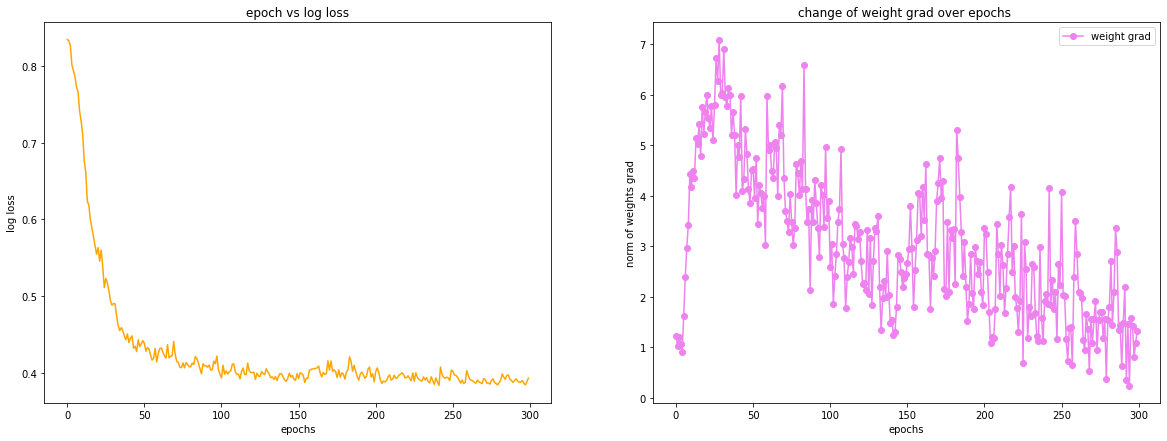

In [33]:
plot(loss,par)

In [34]:
custom_test_dataset = customDataset(test_data, test_y)
custom_test_loader = customDataLoader(custom_test_dataset, batch_size=503)
testdl = custom_test_loader.loader()

In [35]:
loss_fn = nn.CrossEntropyLoss()
loss=0
for i,(xs,ys) in enumerate(testdl):
    xs=xs.to(device)
    ys=ys.to(device)
    pred = modelcnn.forward(xs.type(torch.FloatTensor).cuda())
    pred = torch.argmax(pred, dim = 1)

In [36]:
print("Training accuracy:")
get_accuracy(traindl,modelcnn)
print("validation accuracy:")
get_accuracy(valdl,modelcnn)

Training accuracy:
98.80000352859497 %
validation accuracy:
34.40643846988678 %


0.3440643846988678

In [37]:
print("Loss on test:")
test(modelcnn,testdl)
print("Training accuracy:")
get_accuracy(traindl,modelcnn)
print("Test accuracy:")
get_accuracy(testdl,modelcnn)
print("Training f1 score:")
get_f1(traindl,modelcnn)
print("Test f1 score:")
get_f1(testdl,modelcnn)

Loss on test:
2.072481155395508
Training accuracy:
98.60000610351562 %
Test accuracy:
34.99005734920502 %
Training f1 score:
F1 score: 0.8999999761581421
Test f1 score:
F1 score: 0.36580517888069153


0.36580517888069153

confusion matrix on the test dataset:


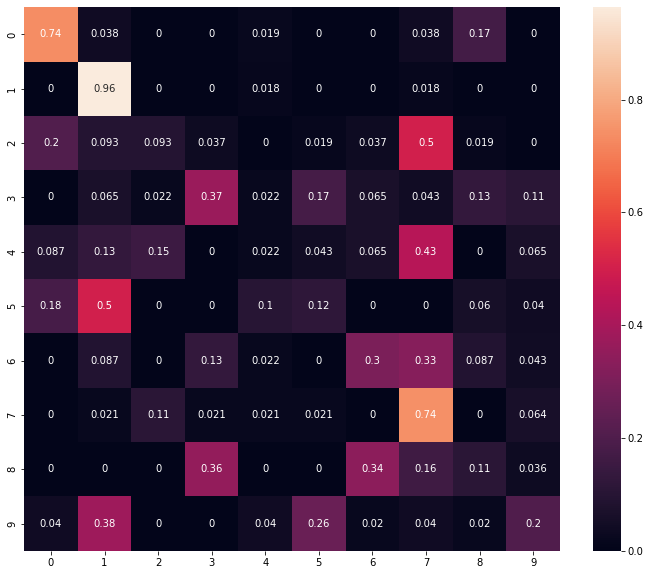

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import accuracy_score

print("confusion matrix on the test dataset:")
confusionplot(testdl,modelcnn)


In [39]:
print("\nThe Classification Report for test set classification\n")
classificationReport(testdl,modelcnn)


The Classification Report for test set classification

              precision    recall  f1-score   support

           0       0.54      0.66      0.59        53
           1       0.41      0.91      0.57        55
           2       0.23      0.06      0.09        54
           3       0.39      0.35      0.37        46
           4       0.12      0.04      0.06        46
           5       0.19      0.10      0.13        50
           6       0.38      0.39      0.39        46
           7       0.31      0.72      0.43        47
           8       0.17      0.09      0.12        56
           9       0.25      0.16      0.20        50

    accuracy                           0.35       503
   macro avg       0.30      0.35      0.29       503
weighted avg       0.30      0.35      0.29       503



When analyzing the speech data of a single speaker (in this case, George), the quantity of data available to train the model is limited. Consequently, the model struggles to generalize effectively on other samples, leading to lower test accuracy (44.7%). Despite this, the model achieves a training accuracy of 98%, indicating low bias and high variance.

In the following section, we have examined various techniques for data augmentation, all of which are applied directly to the raw waveform. These techniques include adding noise to the signal, shifting the time, changing the pitch, and stretching the duration. The results of running models with these different augmentation types are summarized at the end of this section.

## Adding the noise

In [40]:
dummy=np.zeros((1,melspectrogram.shape[0],maxlength+27))
datadict = {'TRAIN':dummy,'DEV':dummy,'TEST':dummy}
labeldict = {'TRAIN':[],'DEV':[],'TEST':[]}
for path,split,label,speaker in zip(sdr_df['file'],sdr_df['split'],sdr_df['label'],sdr_df['speaker']):
    if speaker == 'george':
        x, sr = librosa.load(path, sr=SAMPLING_RATE)
        melspectrogram = extract_melspectrogram(x, sr, num_mels=13)/max_val
        data = torch.tensor(np.concatenate((melspectrogram,np.zeros((melspectrogram.shape[0],maxlength-melspectrogram.shape[1]+27))),axis = 1))## the dimension is made to be 256 so that it works with the maxpooling layers in the architecture.
        data = data.view(1,melspectrogram.shape[0],-1) 
        datadict[split]=torch.tensor(np.concatenate((datadict[split],data),axis=0))
        labeldict[split].append(label)
        
        #adding noise
        noise = np.random.normal(scale=0.001, size=len(x))
        x_with_noise = x + noise
        melspectrogram = extract_melspectrogram(x_with_noise, sr, num_mels=13)/max_val
        data = torch.tensor(np.concatenate((melspectrogram,np.zeros((melspectrogram.shape[0],maxlength-melspectrogram.shape[1]+27))),axis = 1))## the dimension is made to be 256 so that it works with the maxpooling layers in the architecture.
        data = data.view(1,melspectrogram.shape[0],-1) 
        datadict[split]=torch.tensor(np.concatenate((datadict[split],data),axis=0))
        labeldict[split].append(label)       
        
        
train_data = datadict['TRAIN'][1:]
#test_data = datadict['TEST'][1:]
#val_data = datadict['DEV'][1:]
train_y = labeldict['TRAIN'] 
#test_y = labeldict['TEST']
#val_y = labeldict['DEV']

In [41]:
custom_train_dataset = customDataset(train_data, train_y)
custom_train_loader = customDataLoader(custom_train_dataset, batch_size=32)
traindl = custom_train_loader.loader()

custom_test_dataset = customDataset(test_data, test_y)
custom_test_loader = customDataLoader(custom_test_dataset, batch_size=32)
testdl = custom_test_loader.loader()

custom_val_dataset = customDataset(val_data, val_y)
custom_val_loader = customDataLoader(custom_val_dataset, batch_size=32)
valdl = custom_val_loader.loader()

In [42]:
op = 0.2
optim = 'adam'
la = 0.005

In [43]:
modelcnn = cnnModel(13,3,op)
modelcnn.to(device)
loss=[]
par=[]

In [44]:
loss1,par1=modelcnn.train(traindl,epochs = 300,learning_rate=0.001,lam=la,opti=optim)
loss+=loss1
par+=par1
print(test(modelcnn,valdl))

epoch: 0 loss: 2.3043954372406006 grad: 1.2089638402030687
epoch: 1 loss: 2.244344472885132 grad: 1.1647803360374382
epoch: 2 loss: 2.1836063861846924 grad: 1.7082970725714404
epoch: 3 loss: 2.1400721073150635 grad: 2.2334653721482027
epoch: 4 loss: 2.101954460144043 grad: 4.1938118473408394
epoch: 5 loss: 2.023301124572754 grad: 4.5547423544394405
epoch: 6 loss: 1.990156888961792 grad: 4.531200868859742
epoch: 7 loss: 1.9593441486358643 grad: 4.736415788240265
epoch: 8 loss: 1.9276618957519531 grad: 4.671421589573583
epoch: 9 loss: 1.8835283517837524 grad: 4.748288382597821
epoch: 10 loss: 1.8564817905426025 grad: 4.853326988199115
epoch: 11 loss: 1.8368372917175293 grad: 4.95402374126752
epoch: 12 loss: 1.8195369243621826 grad: 6.334618124066765
epoch: 13 loss: 1.7806986570358276 grad: 5.97864179111275
epoch: 14 loss: 1.737082600593567 grad: 6.830452601916477
epoch: 15 loss: 1.7185817956924438 grad: 6.286385419814906
epoch: 16 loss: 1.7264589071273804 grad: 6.491275668908202
epoch: 1

epoch: 139 loss: 1.4860039949417114 grad: 1.8393980395754213
epoch: 140 loss: 1.4882510900497437 grad: 2.32866374375965
epoch: 141 loss: 1.4834082126617432 grad: 2.8614206838276117
epoch: 142 loss: 1.4896790981292725 grad: 2.60868480700234
epoch: 143 loss: 1.4839112758636475 grad: 1.8576612740812921
epoch: 144 loss: 1.483437418937683 grad: 1.1394264765830826
epoch: 145 loss: 1.485461950302124 grad: 1.2248658247111404
epoch: 146 loss: 1.4769375324249268 grad: 1.048847615113944
epoch: 147 loss: 1.4797890186309814 grad: 1.4316623709971728
epoch: 148 loss: 1.484055757522583 grad: 1.4906519858951346
epoch: 149 loss: 1.4771900177001953 grad: 1.4353941389868279
epoch: 150 loss: 1.4809595346450806 grad: 1.7574695067715602
epoch: 151 loss: 1.4888287782669067 grad: 2.948499373471318
epoch: 152 loss: 1.4862385988235474 grad: 1.9399505115157805
epoch: 153 loss: 1.4921153783798218 grad: 2.7450935203440423
epoch: 154 loss: 1.4843361377716064 grad: 1.3561103935374113
epoch: 155 loss: 1.47432315349578

epoch: 275 loss: 1.4719711542129517 grad: 1.2286644786118224
epoch: 276 loss: 1.473044753074646 grad: 0.694062997948595
epoch: 277 loss: 1.470308780670166 grad: 0.5708305021375099
epoch: 278 loss: 1.4715219736099243 grad: 0.41697996374141916
epoch: 279 loss: 1.4712855815887451 grad: 0.5321302410051516
epoch: 280 loss: 1.471039056777954 grad: 1.440318110085181
epoch: 281 loss: 1.4994182586669922 grad: 3.1203466524218335
epoch: 282 loss: 1.487144947052002 grad: 2.7703774441870914
epoch: 283 loss: 1.4964659214019775 grad: 2.971738011764262
epoch: 284 loss: 1.4803892374038696 grad: 1.4414167067092514
epoch: 285 loss: 1.4933009147644043 grad: 1.009021543153698
epoch: 286 loss: 1.4858278036117554 grad: 1.868491606471402
epoch: 287 loss: 1.4791339635849 grad: 1.636303941556161
epoch: 288 loss: 1.483255386352539 grad: 1.4599059128451668
epoch: 289 loss: 1.4755991697311401 grad: 1.7122540944188678
epoch: 290 loss: 1.4792989492416382 grad: 0.9871837001458064
epoch: 291 loss: 1.476650357246399 gr

In [45]:
len(loss)

300

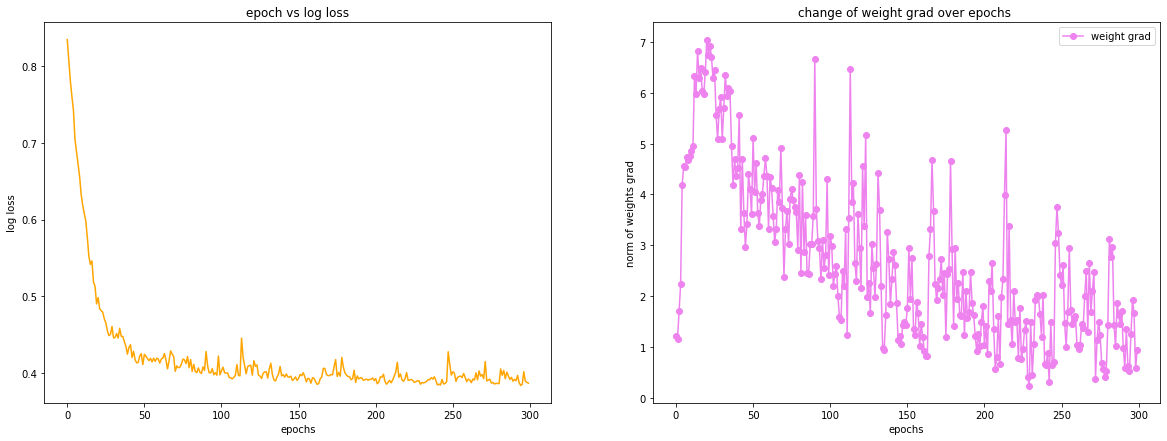

In [46]:
plot(loss,par)

In [47]:
custom_test_dataset = customDataset(test_data, test_y)
custom_test_loader = customDataLoader(custom_test_dataset, batch_size=503)
testdl = custom_test_loader.loader()

In [48]:
loss_fn = nn.CrossEntropyLoss()
loss=0
for i,(xs,ys) in enumerate(testdl):
    xs=xs.to(device)
    ys=ys.to(device)
    pred = modelcnn.forward(xs.type(torch.FloatTensor).cuda())
    pred = torch.argmax(pred, dim = 1)

In [49]:
print("Training accuracy:")
get_accuracy(traindl,modelcnn)
print("validation accuracy:")
get_accuracy(valdl,modelcnn)

Training accuracy:
99.10000562667847 %
validation accuracy:
44.668006896972656 %


0.44668006896972656

In [50]:
print("Loss on test:")
test(modelcnn,testdl)
print("Training accuracy:")
get_accuracy(traindl,modelcnn)
print("Test accuracy:")
get_accuracy(testdl,modelcnn)
print("Training f1 score:")
get_f1(traindl,modelcnn)
print("Test f1 score:")
get_f1(testdl,modelcnn)

Loss on test:
2.0243518352508545
Training accuracy:
99.0000069141388 %
Test accuracy:
45.72564363479614 %
Training f1 score:
F1 score: 1.0
Test f1 score:
F1 score: 0.4393638074398041


0.4393638074398041

confusion matrix on the test dataset:


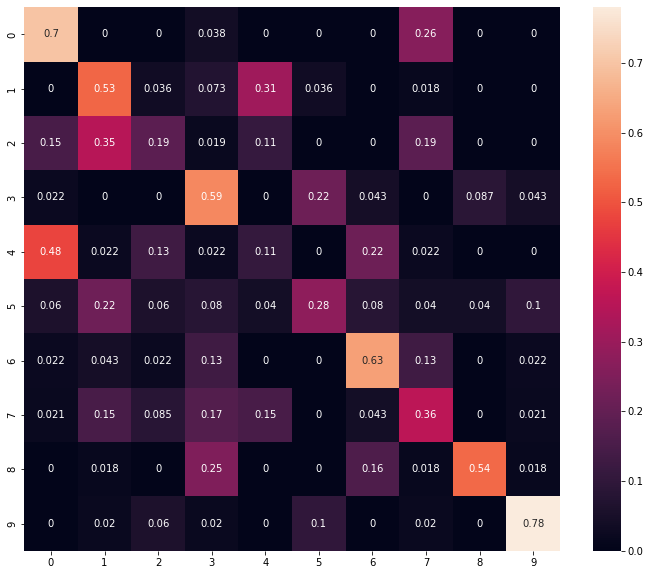

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import accuracy_score

print("confusion matrix on the test dataset:")
confusionplot(testdl,modelcnn)


In [52]:
print("\nThe Classification Report for test set classification\n")
classificationReport(testdl,modelcnn)


The Classification Report for test set classification

              precision    recall  f1-score   support

           0       0.52      0.72      0.60        53
           1       0.35      0.44      0.39        55
           2       0.21      0.13      0.16        54
           3       0.43      0.63      0.51        46
           4       0.18      0.15      0.16        46
           5       0.37      0.26      0.31        50
           6       0.51      0.63      0.56        46
           7       0.39      0.43      0.41        47
           8       0.74      0.46      0.57        56
           9       0.73      0.66      0.69        50

    accuracy                           0.45       503
   macro avg       0.44      0.45      0.44       503
weighted avg       0.45      0.45      0.44       503



## Shifting time

In [53]:
dummy=np.zeros((1,melspectrogram.shape[0],maxlength+27))
datadict = {'TRAIN':dummy,'DEV':dummy,'TEST':dummy}
labeldict = {'TRAIN':[],'DEV':[],'TEST':[]}
for path,split,label,speaker in zip(sdr_df['file'],sdr_df['split'],sdr_df['label'],sdr_df['speaker']):
    if speaker == 'george':
        x, sr = librosa.load(path, sr=SAMPLING_RATE)
        melspectrogram = extract_melspectrogram(x, sr, num_mels=13)/max_val
        data = torch.tensor(np.concatenate((melspectrogram,np.zeros((melspectrogram.shape[0],maxlength-melspectrogram.shape[1]+27))),axis = 1))## the dimension is made to be 256 so that it works with the maxpooling layers in the architecture.
        data = data.view(1,melspectrogram.shape[0],-1) 
        datadict[split]=torch.tensor(np.concatenate((datadict[split],data),axis=0))
        labeldict[split].append(label)
        
        #Shifting time
        x_shifted = manipulate(x, sr, 0.1, 'right')
        melspectrogram = extract_melspectrogram(x_shifted, sr, num_mels=13)/max_val
        data = torch.tensor(np.concatenate((melspectrogram,np.zeros((melspectrogram.shape[0],maxlength-melspectrogram.shape[1]+27))),axis = 1))## the dimension is made to be 256 so that it works with the maxpooling layers in the architecture.
        data = data.view(1,melspectrogram.shape[0],-1) 
        datadict[split]=torch.tensor(np.concatenate((datadict[split],data),axis=0))
        labeldict[split].append(label)   
        
        
train_data = datadict['TRAIN'][1:]
#test_data = datadict['TEST'][1:]
#val_data = datadict['DEV'][1:]
train_y = labeldict['TRAIN'] 
#test_y = labeldict['TEST']
#val_y = labeldict['DEV']

In [54]:
custom_train_dataset = customDataset(train_data, train_y)
custom_train_loader = customDataLoader(custom_train_dataset, batch_size=32)
traindl = custom_train_loader.loader()

custom_test_dataset = customDataset(test_data, test_y)
custom_test_loader = customDataLoader(custom_test_dataset, batch_size=32)
testdl = custom_test_loader.loader()

custom_val_dataset = customDataset(val_data, val_y)
custom_val_loader = customDataLoader(custom_val_dataset, batch_size=32)
valdl = custom_val_loader.loader()

In [55]:
op = 0.2
optim = 'adam'
la = 0.005

In [56]:
modelcnn = cnnModel(13,3,op)
modelcnn.to(device)
loss=[]
par=[]

In [57]:
loss1,par1=modelcnn.train(traindl,epochs = 300,learning_rate=0.001,lam=la,opti=optim)
loss+=loss1
par+=par1
print(test(modelcnn,valdl))

epoch: 0 loss: 2.3051187992095947 grad: 1.2693539228166628
epoch: 1 loss: 2.2938244342803955 grad: 1.2819498802309681
epoch: 2 loss: 2.2595701217651367 grad: 1.8965913301981345
epoch: 3 loss: 2.2224087715148926 grad: 2.419273998184508
epoch: 4 loss: 2.180994749069214 grad: 3.2187615715229185
epoch: 5 loss: 2.10961651802063 grad: 3.769610439940152
epoch: 6 loss: 2.07405161857605 grad: 3.6080196259499644
epoch: 7 loss: 2.0385735034942627 grad: 4.195375825325755
epoch: 8 loss: 2.0021982192993164 grad: 4.945950674307824
epoch: 9 loss: 1.9650206565856934 grad: 5.28258540409297
epoch: 10 loss: 1.920036792755127 grad: 5.846011783454742
epoch: 11 loss: 1.9078269004821777 grad: 5.993782995508809
epoch: 12 loss: 1.8860695362091064 grad: 5.487611788379581
epoch: 13 loss: 1.9000611305236816 grad: 5.848310619703625
epoch: 14 loss: 1.8768501281738281 grad: 4.884812581341976
epoch: 15 loss: 1.8391550779342651 grad: 4.7751225533065735
epoch: 16 loss: 1.8624157905578613 grad: 5.652042016852647
epoch: 1

epoch: 139 loss: 1.4927144050598145 grad: 3.1515537306703294
epoch: 140 loss: 1.5074585676193237 grad: 2.287242113116118
epoch: 141 loss: 1.5006837844848633 grad: 3.1596253025615653
epoch: 142 loss: 1.5122038125991821 grad: 5.531693701315817
epoch: 143 loss: 1.5185387134552002 grad: 4.54717245968709
epoch: 144 loss: 1.50154709815979 grad: 3.4518578990687985
epoch: 145 loss: 1.5130798816680908 grad: 4.484269126820974
epoch: 146 loss: 1.5205122232437134 grad: 3.673184739542137
epoch: 147 loss: 1.5065110921859741 grad: 4.292931568395389
epoch: 148 loss: 1.506966233253479 grad: 3.0461438401360614
epoch: 149 loss: 1.5180414915084839 grad: 4.627528625358632
epoch: 150 loss: 1.5283546447753906 grad: 5.322098295509477
epoch: 151 loss: 1.5037336349487305 grad: 2.431234239812353
epoch: 152 loss: 1.5013668537139893 grad: 3.4615243543976106
epoch: 153 loss: 1.4889607429504395 grad: 1.9861985484563256
epoch: 154 loss: 1.5088329315185547 grad: 3.8123845652464325
epoch: 155 loss: 1.52481210231781 gra

epoch: 276 loss: 1.4912395477294922 grad: 1.7833503631221446
epoch: 277 loss: 1.4901155233383179 grad: 1.6955719945890881
epoch: 278 loss: 1.4802219867706299 grad: 1.766295934681463
epoch: 279 loss: 1.4913994073867798 grad: 2.4604287205637854
epoch: 280 loss: 1.4938108921051025 grad: 1.8314309132400064
epoch: 281 loss: 1.489750862121582 grad: 2.4049252423608865
epoch: 282 loss: 1.4874629974365234 grad: 2.173854807224648
epoch: 283 loss: 1.4914857149124146 grad: 2.7603131980152744
epoch: 284 loss: 1.4938536882400513 grad: 2.9567161030886613
epoch: 285 loss: 1.4979236125946045 grad: 3.100373037324371
epoch: 286 loss: 1.4995652437210083 grad: 2.7688140649817354
epoch: 287 loss: 1.4937469959259033 grad: 2.0881831240277573
epoch: 288 loss: 1.4920321702957153 grad: 1.6250635316190754
epoch: 289 loss: 1.4864095449447632 grad: 1.7855208879645412
epoch: 290 loss: 1.4849302768707275 grad: 1.8163041242690219
epoch: 291 loss: 1.4835774898529053 grad: 1.530771822490684
epoch: 292 loss: 1.4798774719

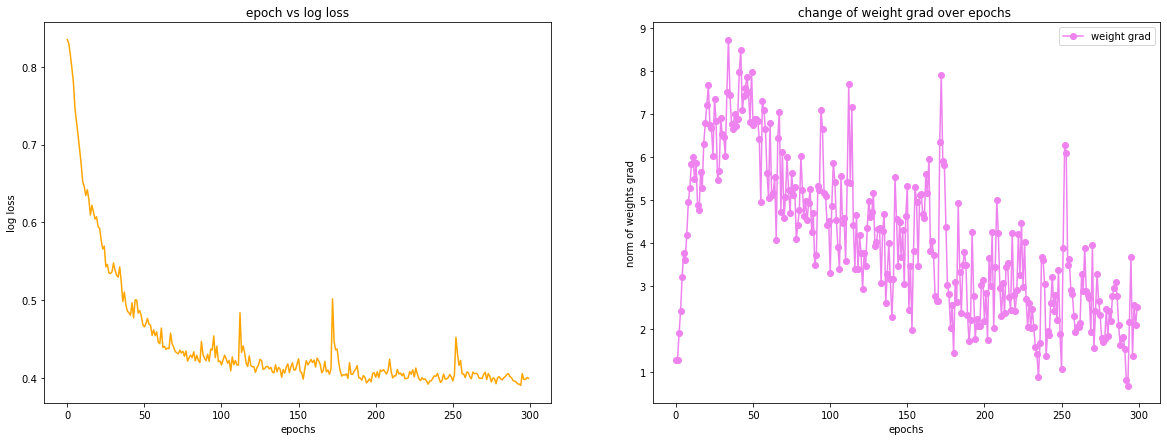

In [58]:
plot(loss,par)

In [59]:
custom_test_dataset = customDataset(test_data, test_y)
custom_test_loader = customDataLoader(custom_test_dataset, batch_size=503)
testdl = custom_test_loader.loader()

In [60]:
loss_fn = nn.CrossEntropyLoss()
loss=0
for i,(xs,ys) in enumerate(testdl):
    xs=xs.to(device)
    ys=ys.to(device)
    pred = modelcnn.forward(xs.type(torch.FloatTensor).cuda())
    pred = torch.argmax(pred, dim = 1)

In [65]:
print("Training accuracy:")
get_accuracy(traindl,modelcnn)
print("validation accuracy:")
get_accuracy(valdl,modelcnn)

Training accuracy:
97.40000367164612 %
validation accuracy:
40.040239691734314 %


0.40040239691734314

In [73]:
print("Loss on test:")
test(modelcnn,testdl)
print("Training accuracy:")
get_accuracy(traindl,modelcnn)
print("Test accuracy:")
get_accuracy(testdl,modelcnn)
print("Training f1 score:")
get_f1(traindl,modelcnn)
print("Test f1 score:")
get_f1(testdl,modelcnn)

Loss on test:
2.1060869693756104
Training accuracy:
97.30000495910645 %
Test accuracy:
36.97812855243683 %
Training f1 score:
F1 score: 1.0
Test f1 score:
F1 score: 0.3598409593105316


0.3598409593105316

confusion matrix on the test dataset:


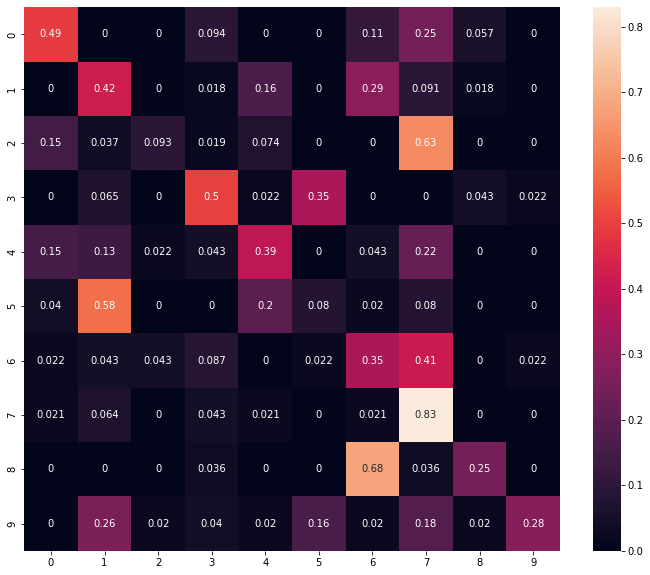

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import accuracy_score

print("confusion matrix on the test dataset:")
confusionplot(testdl,modelcnn)


In [64]:
print("\nThe Classification Report for test set classification\n")
classificationReport(testdl,modelcnn)


The Classification Report for test set classification

              precision    recall  f1-score   support

           0       0.59      0.51      0.55        53
           1       0.28      0.36      0.31        55
           2       0.08      0.02      0.03        54
           3       0.50      0.46      0.48        46
           4       0.39      0.41      0.40        46
           5       0.13      0.08      0.10        50
           6       0.26      0.48      0.33        46
           7       0.31      0.87      0.46        47
           8       0.58      0.20      0.29        56
           9       0.73      0.22      0.34        50

    accuracy                           0.35       503
   macro avg       0.38      0.36      0.33       503
weighted avg       0.39      0.35      0.32       503



## Shifting the pitch

In [74]:
dummy=np.zeros((1,melspectrogram.shape[0],maxlength+27))
datadict = {'TRAIN':dummy,'DEV':dummy,'TEST':dummy}
labeldict = {'TRAIN':[],'DEV':[],'TEST':[]}
for path,split,label,speaker in zip(sdr_df['file'],sdr_df['split'],sdr_df['label'],sdr_df['speaker']):
    if speaker == 'george':
        x, sr = librosa.load(path, sr=SAMPLING_RATE)
        melspectrogram = extract_melspectrogram(x, sr, num_mels=13)/max_val
        data = torch.tensor(np.concatenate((melspectrogram,np.zeros((melspectrogram.shape[0],maxlength-melspectrogram.shape[1]+27))),axis = 1))## the dimension is made to be 256 so that it works with the maxpooling layers in the architecture.
        data = data.view(1,melspectrogram.shape[0],-1) 
        datadict[split]=torch.tensor(np.concatenate((datadict[split],data),axis=0))
        labeldict[split].append(label)
        
        # Shift the pitch of the audio signal
        semitones = 3 # Number of semitones to shift the pitch
        x_pitch = librosa.effects.pitch_shift(x, sr=sr, n_steps=semitones)
        melspectrogram = extract_melspectrogram(x_pitch, sr, num_mels=13)/max_val
        data = torch.tensor(np.concatenate((melspectrogram,np.zeros((melspectrogram.shape[0],maxlength-melspectrogram.shape[1]+27))),axis = 1))## the dimension is made to be 256 so that it works with the maxpooling layers in the architecture.
        data = data.view(1,melspectrogram.shape[0],-1) 
        datadict[split]=torch.tensor(np.concatenate((datadict[split],data),axis=0))
        labeldict[split].append(label)   
        
        
train_data = datadict['TRAIN'][1:]
#test_data = datadict['TEST'][1:]
#val_data = datadict['DEV'][1:]
train_y = labeldict['TRAIN'] 
#test_y = labeldict['TEST']
#val_y = labeldict['DEV']

In [75]:
custom_train_dataset = customDataset(train_data, train_y)
custom_train_loader = customDataLoader(custom_train_dataset, batch_size=32)
traindl = custom_train_loader.loader()

custom_test_dataset = customDataset(test_data, test_y)
custom_test_loader = customDataLoader(custom_test_dataset, batch_size=32)
testdl = custom_test_loader.loader()

custom_val_dataset = customDataset(val_data, val_y)
custom_val_loader = customDataLoader(custom_val_dataset, batch_size=32)
valdl = custom_val_loader.loader()

In [76]:
op = 0.2
optim = 'adam'
la = 0.005

In [77]:
modelcnn = cnnModel(13,3,op)
modelcnn.to(device)
loss=[]
par=[]

In [78]:
loss1,par1=modelcnn.train(traindl,epochs = 300,learning_rate=0.001,lam=la,opti=optim)
loss+=loss1
par+=par1
print(test(modelcnn,valdl))

epoch: 0 loss: 2.303483247756958 grad: 1.2752250619760161
epoch: 1 loss: 2.2790918350219727 grad: 1.5555139718853752
epoch: 2 loss: 2.2045094966888428 grad: 2.7998293539985752
epoch: 3 loss: 2.1313984394073486 grad: 3.1189565899476293
epoch: 4 loss: 2.067096710205078 grad: 3.9658797214578954
epoch: 5 loss: 2.018752336502075 grad: 4.710097121740546
epoch: 6 loss: 1.973093867301941 grad: 4.824092788672715
epoch: 7 loss: 1.9295189380645752 grad: 4.684706557283789
epoch: 8 loss: 1.8803045749664307 grad: 5.908016607030731
epoch: 9 loss: 1.8660264015197754 grad: 6.1406869603233645
epoch: 10 loss: 1.8244452476501465 grad: 5.521757000959042
epoch: 11 loss: 1.7790465354919434 grad: 5.9260584327203105
epoch: 12 loss: 1.7757889032363892 grad: 5.835288453119574
epoch: 13 loss: 1.7617579698562622 grad: 6.161132854802418
epoch: 14 loss: 1.7731995582580566 grad: 6.305505250897113
epoch: 15 loss: 1.750004529953003 grad: 7.128444513313298
epoch: 16 loss: 1.7406795024871826 grad: 6.457885504732985
epoch

epoch: 139 loss: 1.5172640085220337 grad: 2.8297199170621785
epoch: 140 loss: 1.531747817993164 grad: 4.424710484974852
epoch: 141 loss: 1.52055823802948 grad: 3.3493838135250087
epoch: 142 loss: 1.514055848121643 grad: 3.6549412888228083
epoch: 143 loss: 1.5056287050247192 grad: 2.6461861371928563
epoch: 144 loss: 1.5069934129714966 grad: 3.112734964276524
epoch: 145 loss: 1.5069332122802734 grad: 2.144512598452642
epoch: 146 loss: 1.5225579738616943 grad: 5.191895490179759
epoch: 147 loss: 1.5171873569488525 grad: 3.314281469271013
epoch: 148 loss: 1.5385222434997559 grad: 5.468385844967485
epoch: 149 loss: 1.5167524814605713 grad: 3.167381426332426
epoch: 150 loss: 1.5136715173721313 grad: 2.231600141609296
epoch: 151 loss: 1.5042442083358765 grad: 3.4876155567314058
epoch: 152 loss: 1.53635835647583 grad: 4.360154787166319
epoch: 153 loss: 1.5260899066925049 grad: 4.824329084983447
epoch: 154 loss: 1.5187413692474365 grad: 2.471619453006383
epoch: 155 loss: 1.5127472877502441 grad:

epoch: 276 loss: 1.5250808000564575 grad: 2.7904667622149395
epoch: 277 loss: 1.5120699405670166 grad: 2.9594000530042224
epoch: 278 loss: 1.5112522840499878 grad: 2.953441087176496
epoch: 279 loss: 1.513536810874939 grad: 3.43623662528429
epoch: 280 loss: 1.4938712120056152 grad: 2.624414100364608
epoch: 281 loss: 1.4983080625534058 grad: 2.2460185255689926
epoch: 282 loss: 1.496142864227295 grad: 1.0143155198100842
epoch: 283 loss: 1.4864318370819092 grad: 2.4292842184208907
epoch: 284 loss: 1.5022155046463013 grad: 3.797121098796732
epoch: 285 loss: 1.4967854022979736 grad: 3.884536443258429
epoch: 286 loss: 1.5237513780593872 grad: 3.4586704919426934
epoch: 287 loss: 1.5187938213348389 grad: 3.3497954604193296
epoch: 288 loss: 1.493926763534546 grad: 2.1088878468493917
epoch: 289 loss: 1.4963033199310303 grad: 1.0513735961390294
epoch: 290 loss: 1.4947868585586548 grad: 2.691149032184293
epoch: 291 loss: 1.497201919555664 grad: 2.387623196400613
epoch: 292 loss: 1.5144298076629639 

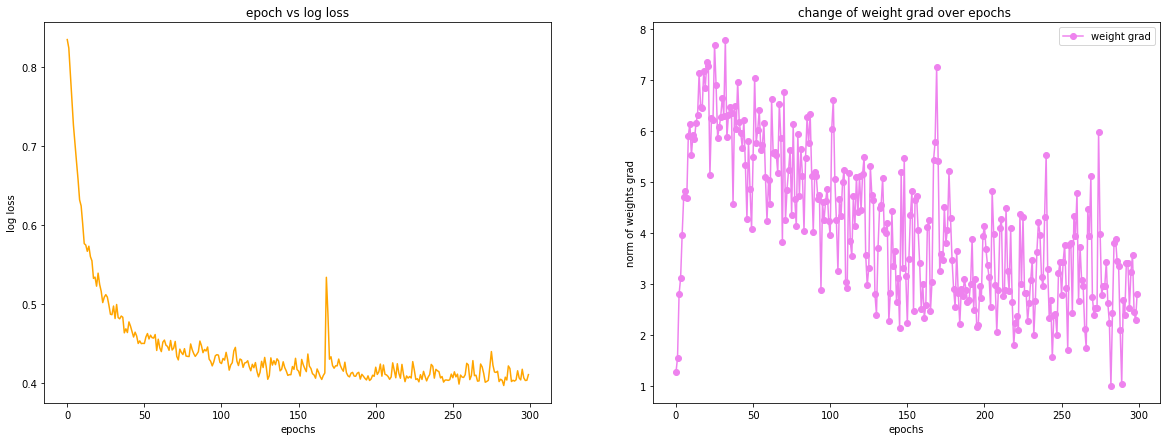

In [79]:
plot(loss,par)

In [80]:
custom_test_dataset = customDataset(test_data, test_y)
custom_test_loader = customDataLoader(custom_test_dataset, batch_size=503)
testdl = custom_test_loader.loader()

In [81]:
loss_fn = nn.CrossEntropyLoss()
loss=0
for i,(xs,ys) in enumerate(testdl):
    xs=xs.to(device)
    ys=ys.to(device)
    pred = modelcnn.forward(xs.type(torch.FloatTensor).cuda())
    pred = torch.argmax(pred, dim = 1)

In [82]:
print("Training accuracy:")
get_accuracy(traindl,modelcnn)
print("validation accuracy:")
get_accuracy(valdl,modelcnn)

Training accuracy:
94.50000524520874 %
validation accuracy:
45.67404389381409 %


0.45674043893814087

In [83]:
print("Loss on test:")
test(modelcnn,testdl)
print("Training accuracy:")
get_accuracy(traindl,modelcnn)
print("Test accuracy:")
get_accuracy(testdl,modelcnn)
print("Training f1 score:")
get_f1(traindl,modelcnn)
print("Test f1 score:")
get_f1(testdl,modelcnn)

Loss on test:
1.9986573457717896
Training accuracy:
94.50000524520874 %
Test accuracy:
45.526838302612305 %
Training f1 score:
F1 score: 1.0
Test f1 score:
F1 score: 0.4632206857204437


0.4632206857204437

confusion matrix on the test dataset:


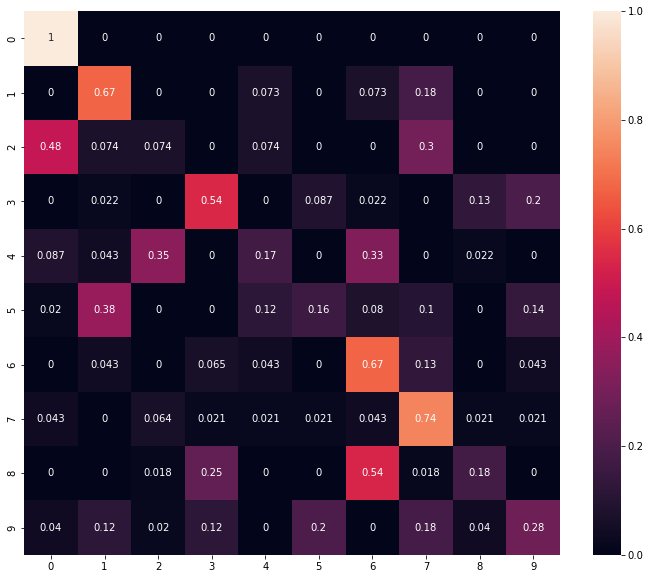

In [84]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import accuracy_score

print("confusion matrix on the test dataset:")
confusionplot(testdl,modelcnn)


In [85]:
print("\nThe Classification Report for test set classification\n")
classificationReport(testdl,modelcnn)


The Classification Report for test set classification

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        53
           1       0.49      0.64      0.55        55
           2       0.21      0.11      0.14        54
           3       0.52      0.54      0.53        46
           4       0.32      0.20      0.24        46
           5       0.42      0.16      0.23        50
           6       0.40      0.74      0.52        46
           7       0.45      0.70      0.55        47
           8       0.54      0.23      0.33        56
           9       0.51      0.40      0.45        50

    accuracy                           0.47       503
   macro avg       0.45      0.47      0.43       503
weighted avg       0.45      0.47      0.43       503



## Stretch the duration

In [86]:
dummy=np.zeros((1,melspectrogram.shape[0],maxlength+27))
datadict = {'TRAIN':dummy,'DEV':dummy,'TEST':dummy}
labeldict = {'TRAIN':[],'DEV':[],'TEST':[]}
for path,split,label,speaker in zip(sdr_df['file'],sdr_df['split'],sdr_df['label'],sdr_df['speaker']):
    if speaker == 'george':
        x, sr = librosa.load(path, sr=SAMPLING_RATE)
        melspectrogram = extract_melspectrogram(x, sr, num_mels=13)/max_val
        data = torch.tensor(np.concatenate((melspectrogram,np.zeros((melspectrogram.shape[0],maxlength-melspectrogram.shape[1]+27))),axis = 1))## the dimension is made to be 256 so that it works with the maxpooling layers in the architecture.
        data = data.view(1,melspectrogram.shape[0],-1) 
        datadict[split]=torch.tensor(np.concatenate((datadict[split],data),axis=0))
        labeldict[split].append(label)
        
        # Stretch the duration of the audio signal
        stretch_factor = 1.3 # Factor by which to stretch the duration
        x_stretched = librosa.effects.time_stretch(x, rate=stretch_factor)
        melspectrogram = extract_melspectrogram(x_stretched, sr, num_mels=13)/max_val
        data = torch.tensor(np.concatenate((melspectrogram,np.zeros((melspectrogram.shape[0],maxlength-melspectrogram.shape[1]+27))),axis = 1))## the dimension is made to be 256 so that it works with the maxpooling layers in the architecture.
        data = data.view(1,melspectrogram.shape[0],-1) 
        datadict[split]=torch.tensor(np.concatenate((datadict[split],data),axis=0))
        labeldict[split].append(label)     
        
        
train_data = datadict['TRAIN'][1:]
#test_data = datadict['TEST'][1:]
#val_data = datadict['DEV'][1:]
train_y = labeldict['TRAIN'] 
#test_y = labeldict['TEST']
#val_y = labeldict['DEV']

In [87]:
custom_train_dataset = customDataset(train_data, train_y)
custom_train_loader = customDataLoader(custom_train_dataset, batch_size=32)
traindl = custom_train_loader.loader()

custom_test_dataset = customDataset(test_data, test_y)
custom_test_loader = customDataLoader(custom_test_dataset, batch_size=32)
testdl = custom_test_loader.loader()

custom_val_dataset = customDataset(val_data, val_y)
custom_val_loader = customDataLoader(custom_val_dataset, batch_size=32)
valdl = custom_val_loader.loader()

In [88]:
op = 0.2
optim = 'adam'
la = 0.005

In [89]:
modelcnn = cnnModel(13,3,op)
modelcnn.to(device)
loss=[]
par=[]

In [90]:
loss1,par1=modelcnn.train(traindl,epochs = 300,learning_rate=0.001,lam=la,opti=optim)
loss+=loss1
par+=par1
print(test(modelcnn,valdl))

epoch: 0 loss: 2.3059799671173096 grad: 1.2315639880034723
epoch: 1 loss: 2.286268949508667 grad: 1.023972350274562
epoch: 2 loss: 2.230114459991455 grad: 1.0499175069826379
epoch: 3 loss: 2.176755666732788 grad: 1.8119642620904415
epoch: 4 loss: 2.138089418411255 grad: 1.7771381736547482
epoch: 5 loss: 2.107883930206299 grad: 3.1476537287999236
epoch: 6 loss: 2.078205108642578 grad: 3.944902705196
epoch: 7 loss: 2.066314697265625 grad: 3.352756475449496
epoch: 8 loss: 2.0159640312194824 grad: 3.9217035558231146
epoch: 9 loss: 1.9734972715377808 grad: 4.209129231481711
epoch: 10 loss: 1.9507226943969727 grad: 5.230772860133584
epoch: 11 loss: 1.9127002954483032 grad: 5.166194569444997
epoch: 12 loss: 1.936777114868164 grad: 5.4787543584134255
epoch: 13 loss: 1.8711352348327637 grad: 5.229298430058407
epoch: 14 loss: 1.8477153778076172 grad: 5.963201011691126
epoch: 15 loss: 1.8599040508270264 grad: 5.111880545024178
epoch: 16 loss: 1.8465155363082886 grad: 6.455237321315508
epoch: 17 l

epoch: 139 loss: 1.4969037771224976 grad: 1.6241029418650015
epoch: 140 loss: 1.4971563816070557 grad: 2.532958899786582
epoch: 141 loss: 1.5002754926681519 grad: 2.367444360826255
epoch: 142 loss: 1.4874963760375977 grad: 2.1949516556299957
epoch: 143 loss: 1.4893141984939575 grad: 1.3476808738490178
epoch: 144 loss: 1.4992643594741821 grad: 1.9916474226077467
epoch: 145 loss: 1.4905897378921509 grad: 2.263032598297328
epoch: 146 loss: 1.4923232793807983 grad: 2.176049215239372
epoch: 147 loss: 1.4961891174316406 grad: 3.1071838321364873
epoch: 148 loss: 1.5268036127090454 grad: 4.8198082906464785
epoch: 149 loss: 1.5226513147354126 grad: 4.059190064152627
epoch: 150 loss: 1.5232698917388916 grad: 4.049798072663471
epoch: 151 loss: 1.5224183797836304 grad: 5.413428091143523
epoch: 152 loss: 1.5541596412658691 grad: 6.657847078847567
epoch: 153 loss: 1.5257476568222046 grad: 3.1088748226011638
epoch: 154 loss: 1.5140578746795654 grad: 3.424091463167816
epoch: 155 loss: 1.49669444561004

epoch: 275 loss: 1.4829907417297363 grad: 2.045647680113213
epoch: 276 loss: 1.479984998703003 grad: 2.1866155946144454
epoch: 277 loss: 1.48468816280365 grad: 1.0924496387928704
epoch: 278 loss: 1.4748907089233398 grad: 1.560025895800336
epoch: 279 loss: 1.4792611598968506 grad: 1.7498089524987503
epoch: 280 loss: 1.4790639877319336 grad: 1.3465844257925441
epoch: 281 loss: 1.475342035293579 grad: 1.1261170803939502
epoch: 282 loss: 1.480003833770752 grad: 2.491733184872736
epoch: 283 loss: 1.4874110221862793 grad: 3.4395721668952586
epoch: 284 loss: 1.481007695198059 grad: 1.469841781051905
epoch: 285 loss: 1.4939340353012085 grad: 2.0999070379920215
epoch: 286 loss: 1.4958292245864868 grad: 2.2309984155424063
epoch: 287 loss: 1.4846984148025513 grad: 2.294283518104904
epoch: 288 loss: 1.491398572921753 grad: 2.604559562379249
epoch: 289 loss: 1.5007951259613037 grad: 2.6783505167168165
epoch: 290 loss: 1.4859760999679565 grad: 1.8948440140048524
epoch: 291 loss: 1.4773788452148438 g

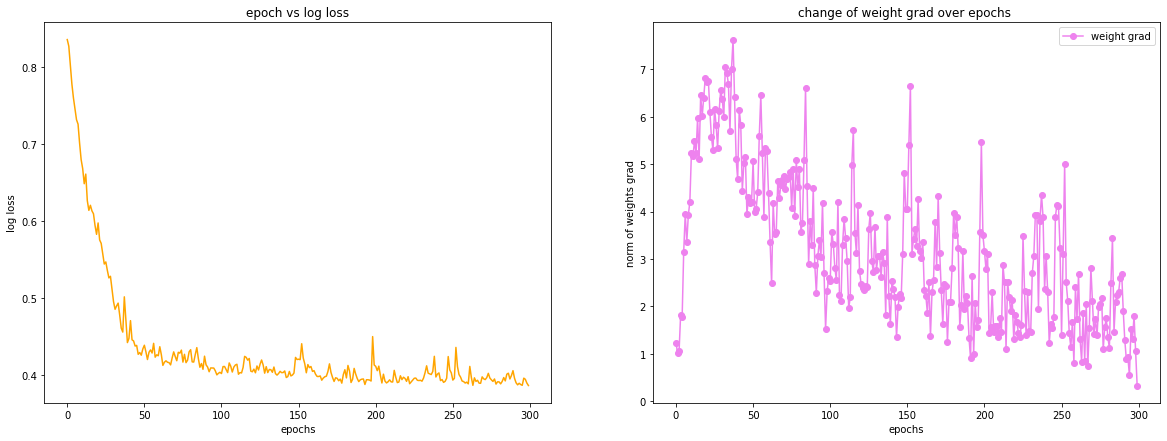

In [91]:
plot(loss,par)

In [92]:
custom_test_dataset = customDataset(test_data, test_y)
custom_test_loader = customDataLoader(custom_test_dataset, batch_size=503)
testdl = custom_test_loader.loader()

In [93]:
loss_fn = nn.CrossEntropyLoss()
loss=0
for i,(xs,ys) in enumerate(testdl):
    xs=xs.to(device)
    ys=ys.to(device)
    pred = modelcnn.forward(xs.type(torch.FloatTensor).cuda())
    pred = torch.argmax(pred, dim = 1)

In [99]:
print("Training accuracy:")
get_accuracy(traindl,modelcnn)
print("validation accuracy:")
get_accuracy(valdl,modelcnn)

Training accuracy:
98.7000048160553 %
validation accuracy:
36.217302083969116 %


0.36217302083969116

In [98]:
print("Loss on test:")
test(modelcnn,testdl)
print("Training accuracy:")
get_accuracy(traindl,modelcnn)
print("Test accuracy:")
get_accuracy(testdl,modelcnn)
print("Training f1 score:")
get_f1(traindl,modelcnn)
print("Test f1 score:")
get_f1(testdl,modelcnn)

Loss on test:
2.095792531967163
Training accuracy:
98.7000048160553 %
Test accuracy:
38.17097246646881 %
Training f1 score:
F1 score: 1.0
Test f1 score:
F1 score: 0.3677932322025299


0.3677932322025299

confusion matrix on the test dataset:


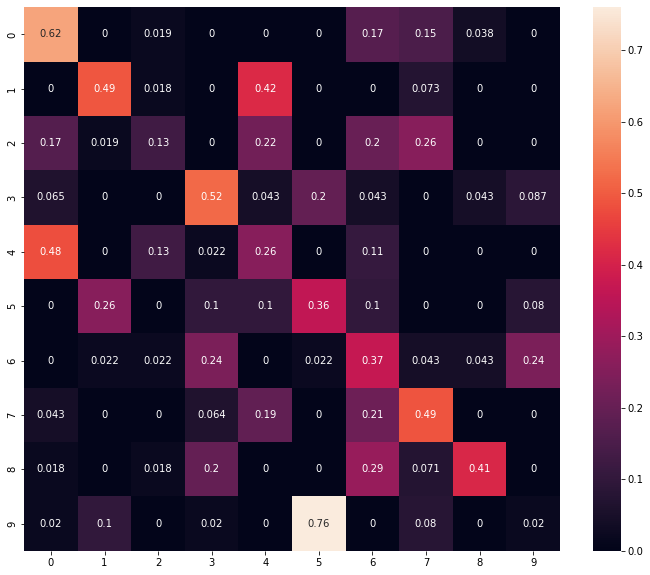

In [96]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import accuracy_score

print("confusion matrix on the test dataset:")
confusionplot(testdl,modelcnn)


In [97]:
print("\nThe Classification Report for test set classification\n")
classificationReport(testdl,modelcnn)


The Classification Report for test set classification

              precision    recall  f1-score   support

           0       0.55      0.68      0.61        53
           1       0.62      0.56      0.59        55
           2       0.36      0.15      0.21        54
           3       0.34      0.43      0.38        46
           4       0.23      0.30      0.26        46
           5       0.24      0.36      0.29        50
           6       0.24      0.35      0.29        46
           7       0.43      0.49      0.46        47
           8       0.83      0.43      0.56        56
           9       0.04      0.02      0.03        50

    accuracy                           0.38       503
   macro avg       0.39      0.38      0.37       503
weighted avg       0.40      0.38      0.37       503



## Mix

In [100]:
dummy=np.zeros((1,melspectrogram.shape[0],maxlength+27))
datadict = {'TRAIN':dummy,'DEV':dummy,'TEST':dummy}
labeldict = {'TRAIN':[],'DEV':[],'TEST':[]}
for path,split,label,speaker in zip(sdr_df['file'],sdr_df['split'],sdr_df['label'],sdr_df['speaker']):
    if speaker == 'george':
        x, sr = librosa.load(path, sr=SAMPLING_RATE)
        melspectrogram = extract_melspectrogram(x, sr, num_mels=13)/max_val
        data = torch.tensor(np.concatenate((melspectrogram,np.zeros((melspectrogram.shape[0],maxlength-melspectrogram.shape[1]+27))),axis = 1))## the dimension is made to be 256 so that it works with the maxpooling layers in the architecture.
        data = data.view(1,melspectrogram.shape[0],-1) 
        datadict[split]=torch.tensor(np.concatenate((datadict[split],data),axis=0))
        labeldict[split].append(label)
        
        #adding noise
        noise = np.random.normal(scale=0.001, size=len(x))
        x_with_noise = x + noise
        melspectrogram = extract_melspectrogram(x_with_noise, sr, num_mels=13)/max_val
        data = torch.tensor(np.concatenate((melspectrogram,np.zeros((melspectrogram.shape[0],maxlength-melspectrogram.shape[1]+27))),axis = 1))## the dimension is made to be 256 so that it works with the maxpooling layers in the architecture.
        data = data.view(1,melspectrogram.shape[0],-1) 
        datadict[split]=torch.tensor(np.concatenate((datadict[split],data),axis=0))
        labeldict[split].append(label)
        
        #Shifting time
        x_shifted = manipulate(x, sr, 0.1, 'right')
        melspectrogram = extract_melspectrogram(x_shifted, sr, num_mels=13)/max_val
        data = torch.tensor(np.concatenate((melspectrogram,np.zeros((melspectrogram.shape[0],maxlength-melspectrogram.shape[1]+27))),axis = 1))## the dimension is made to be 256 so that it works with the maxpooling layers in the architecture.
        data = data.view(1,melspectrogram.shape[0],-1) 
        datadict[split]=torch.tensor(np.concatenate((datadict[split],data),axis=0))
        labeldict[split].append(label)
        
        # Shift the pitch of the audio signal
        semitones = 3 # Number of semitones to shift the pitch
        x_pitch = librosa.effects.pitch_shift(x, sr=sr, n_steps=semitones)
        melspectrogram = extract_melspectrogram(x_pitch, sr, num_mels=13)/max_val
        data = torch.tensor(np.concatenate((melspectrogram,np.zeros((melspectrogram.shape[0],maxlength-melspectrogram.shape[1]+27))),axis = 1))## the dimension is made to be 256 so that it works with the maxpooling layers in the architecture.
        data = data.view(1,melspectrogram.shape[0],-1) 
        datadict[split]=torch.tensor(np.concatenate((datadict[split],data),axis=0))
        labeldict[split].append(label)
        
        # Stretch the duration of the audio signal
        stretch_factor = 1.3 # Factor by which to stretch the duration
        x_stretched = librosa.effects.time_stretch(x, rate=stretch_factor)
        melspectrogram = extract_melspectrogram(x_stretched, sr, num_mels=13)/max_val
        data = torch.tensor(np.concatenate((melspectrogram,np.zeros((melspectrogram.shape[0],maxlength-melspectrogram.shape[1]+27))),axis = 1))## the dimension is made to be 256 so that it works with the maxpooling layers in the architecture.
        data = data.view(1,melspectrogram.shape[0],-1) 
        datadict[split]=torch.tensor(np.concatenate((datadict[split],data),axis=0))
        labeldict[split].append(label)        
        
        
train_data = datadict['TRAIN'][1:]
#test_data = datadict['TEST'][1:]
#val_data = datadict['DEV'][1:]
train_y = labeldict['TRAIN'] 
#test_y = labeldict['TEST']
#val_y = labeldict['DEV']

In [101]:
custom_train_dataset = customDataset(train_data, train_y)
custom_train_loader = customDataLoader(custom_train_dataset, batch_size=32)
traindl = custom_train_loader.loader()

custom_test_dataset = customDataset(test_data, test_y)
custom_test_loader = customDataLoader(custom_test_dataset, batch_size=32)
testdl = custom_test_loader.loader()

custom_val_dataset = customDataset(val_data, val_y)
custom_val_loader = customDataLoader(custom_val_dataset, batch_size=32)
valdl = custom_val_loader.loader()

In [102]:
op = 0.2
optim = 'adam'
la = 0.005

In [103]:
modelcnn = cnnModel(13,3,op)
modelcnn.to(device)
loss=[]
par=[]

In [104]:
loss1,par1=modelcnn.train(traindl,epochs = 300,learning_rate=0.001,lam=la,opti=optim)
loss+=loss1
par+=par1
print(test(modelcnn,valdl))

epoch: 0 loss: 2.300454616546631 grad: 1.150966505678459
epoch: 1 loss: 2.2266762256622314 grad: 1.4522580008639194
epoch: 2 loss: 2.1820123195648193 grad: 2.048320235486866
epoch: 3 loss: 2.1370182037353516 grad: 2.8935679472950464
epoch: 4 loss: 2.0633578300476074 grad: 4.364606773897437
epoch: 5 loss: 1.9990429878234863 grad: 4.574554198064187
epoch: 6 loss: 1.9851192235946655 grad: 4.928234794280452
epoch: 7 loss: 1.9512578248977661 grad: 5.333424599504517
epoch: 8 loss: 1.9302973747253418 grad: 5.5611021933672635
epoch: 9 loss: 1.9191335439682007 grad: 5.7504469645754845
epoch: 10 loss: 1.877403736114502 grad: 5.811339393173362
epoch: 11 loss: 1.8834819793701172 grad: 5.8915408539815655
epoch: 12 loss: 1.8573946952819824 grad: 6.1270520643959605
epoch: 13 loss: 1.8352781534194946 grad: 6.786368015273828
epoch: 14 loss: 1.8591563701629639 grad: 7.14006190418131
epoch: 15 loss: 1.8454878330230713 grad: 7.463683839404773
epoch: 16 loss: 1.8269107341766357 grad: 6.078371620692163
epoc

epoch: 139 loss: 1.5323110818862915 grad: 4.337186534455406
epoch: 140 loss: 1.5463052988052368 grad: 4.231816469066861
epoch: 141 loss: 1.530780553817749 grad: 2.7547282499001797
epoch: 142 loss: 1.526535987854004 grad: 3.3186038889930547
epoch: 143 loss: 1.5414048433303833 grad: 3.5774332849068466
epoch: 144 loss: 1.5344566106796265 grad: 3.8146707548087124
epoch: 145 loss: 1.543212890625 grad: 4.639241141357969
epoch: 146 loss: 1.5437207221984863 grad: 5.762347531382129
epoch: 147 loss: 1.5286295413970947 grad: 3.7210972169975474
epoch: 148 loss: 1.5468679666519165 grad: 4.575375349052978
epoch: 149 loss: 1.5246713161468506 grad: 3.4156126431216194
epoch: 150 loss: 1.5301213264465332 grad: 4.68984151888119
epoch: 151 loss: 1.5353565216064453 grad: 4.759319097637267
epoch: 152 loss: 1.547533631324768 grad: 5.268048778666419
epoch: 153 loss: 1.5729269981384277 grad: 5.984624396112809
epoch: 154 loss: 1.5336652994155884 grad: 4.600043683201278
epoch: 155 loss: 1.5282924175262451 grad: 

epoch: 276 loss: 1.5060724020004272 grad: 3.0709129228133247
epoch: 277 loss: 1.500016450881958 grad: 2.0000969718205863
epoch: 278 loss: 1.5353102684020996 grad: 3.5104720669070737
epoch: 279 loss: 1.5248428583145142 grad: 3.3557043190062386
epoch: 280 loss: 1.5274803638458252 grad: 4.155528348177654
epoch: 281 loss: 1.5060948133468628 grad: 2.4853122141798325
epoch: 282 loss: 1.52213716506958 grad: 3.3021658145710333
epoch: 283 loss: 1.5129386186599731 grad: 2.7383426570167497
epoch: 284 loss: 1.5029951333999634 grad: 2.0259364842660417
epoch: 285 loss: 1.508763313293457 grad: 2.133237824076709
epoch: 286 loss: 1.5144416093826294 grad: 3.3068598143195223
epoch: 287 loss: 1.5167135000228882 grad: 2.9971074564560247
epoch: 288 loss: 1.512850046157837 grad: 3.23676177859737
epoch: 289 loss: 1.521613359451294 grad: 3.2693605378799764
epoch: 290 loss: 1.511171817779541 grad: 3.12578219634631
epoch: 291 loss: 1.516149878501892 grad: 3.4412950945083374
epoch: 292 loss: 1.5627362728118896 gr

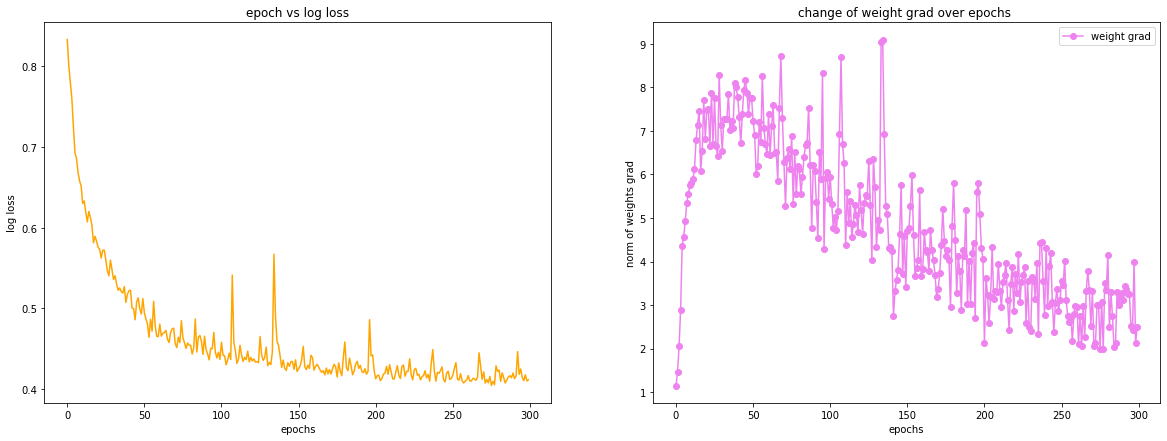

In [105]:
plot(loss,par)

In [106]:
custom_test_dataset = customDataset(test_data, test_y)
custom_test_loader = customDataLoader(custom_test_dataset, batch_size=503)
testdl = custom_test_loader.loader()

In [107]:
loss_fn = nn.CrossEntropyLoss()
loss=0
for i,(xs,ys) in enumerate(testdl):
    xs=xs.to(device)
    ys=ys.to(device)
    pred = modelcnn.forward(xs.type(torch.FloatTensor).cuda())
    pred = torch.argmax(pred, dim = 1)

In [112]:
print("Training accuracy:")
get_accuracy(traindl,modelcnn)
print("validation accuracy:")
get_accuracy(valdl,modelcnn)

Training accuracy:
96.31999731063843 %
validation accuracy:
48.490944504737854 %


0.48490944504737854

In [113]:
print("Loss on test:")
test(modelcnn,testdl)
print("Training accuracy:")
get_accuracy(traindl,modelcnn)
print("Test accuracy:")
get_accuracy(testdl,modelcnn)
print("Training f1 score:")
get_f1(traindl,modelcnn)
print("Test f1 score:")
get_f1(testdl,modelcnn)

Loss on test:
1.9879462718963623
Training accuracy:
96.55999541282654 %
Test accuracy:
47.91252315044403 %
Training f1 score:
F1 score: 1.0
Test f1 score:
F1 score: 0.4652087390422821


0.4652087390422821

confusion matrix on the test dataset:


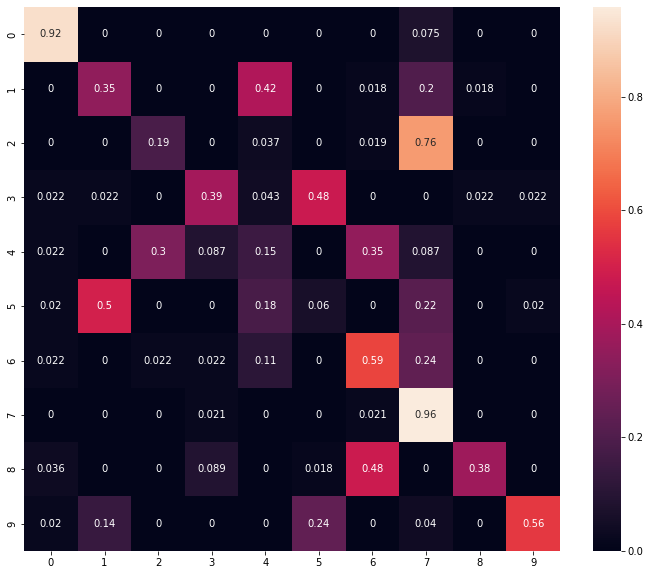

In [114]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import accuracy_score

print("confusion matrix on the test dataset:")
confusionplot(testdl,modelcnn)


In [115]:
print("\nThe Classification Report for test set classification\n")
classificationReport(testdl,modelcnn)


The Classification Report for test set classification

              precision    recall  f1-score   support

           0       0.89      0.92      0.91        53
           1       0.31      0.29      0.30        55
           2       0.35      0.20      0.26        54
           3       0.75      0.39      0.51        46
           4       0.14      0.13      0.13        46
           5       0.09      0.08      0.08        50
           6       0.41      0.78      0.54        46
           7       0.37      0.91      0.53        47
           8       0.95      0.34      0.50        56
           9       0.93      0.52      0.67        50

    accuracy                           0.45       503
   macro avg       0.52      0.46      0.44       503
weighted avg       0.53      0.45      0.44       503



In the preceding discussion, we have explored several techniques for data augmentation that are applied directly to the raw waveform. These techniques aim to increase the amount of data available by introducing variations such as adding noise, shifting time and pitch, stretching duration, and combining these approaches. The results demonstrate that applying data augmentation led to improved performance in all models, suggesting that they achieved better generalization. Notably, using a combination of all augmentation techniques produced the highest testing accuracy of 48%. The modelcwhich used only time shift augmentation has the least testing accuracy of 37%. 